In [1]:
# pip install cassandra-driver pandas

In [2]:
from cassandra.cluster import Cluster
import pandas as pd

# Connect to Cassandra (host IP is separated from the port number)
cluster = Cluster(['localhost'], port=9042)  # Replace '172.19.0.1' with the appropriate host IP if needed
session = cluster.connect('iot_stations')  # Connect to your keyspace

# Query to select all rows from your table
query = "SELECT * FROM spark_stream;"
rows = session.execute(query)

# Convert the query result to a list of dictionaries
data = [dict(row._asdict()) for row in rows]

# Convert to a pandas DataFrame
df = pd.DataFrame(data)

# Convert 'record_time' column to datetime
df['record_time'] = pd.to_datetime(df['record_time'])

# Save DataFrame to a CSV file
# df.to_csv('spark_stream_data.csv', index=False)
# print("Data saved to spark_stream_data.csv")

# Close the connection
cluster.shutdown()

In [3]:
df[df['is_outlier'] == True].sort_values(by='record_time',ascending=False).head(5)

,station_id,record_time,humidity,is_outlier,noise_level,temperature
17156,station_533c065cc,2024-09-03 11:11:35.389,50.647131,True,41.289508,17.354711
12257,station_94067fa98,2024-09-03 11:10:47.582,71.032385,True,42.205211,17.835852
88851,station_c467ea999,2024-09-03 11:09:14.024,58.490469,True,37.653544,34.432605
67646,station_3c1756e1b,2024-09-03 11:08:59.990,49.554864,True,38.130635,27.783305
118686,station_afc51cdb3,2024-09-03 11:08:57.299,47.973152,True,59.719376,31.232067


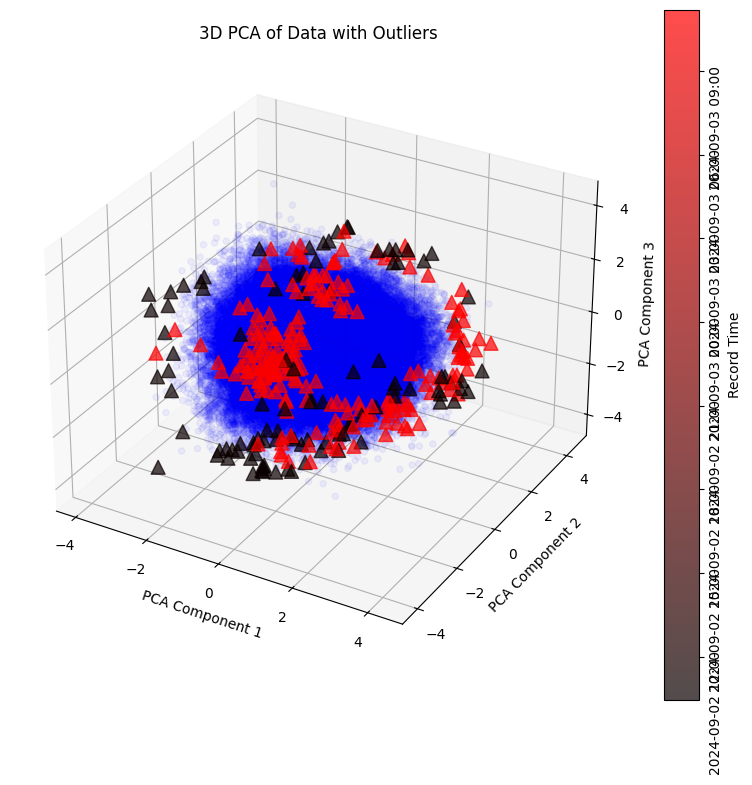

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

###########################################################################################################
###### Inspect new datarows and how the outliers change while getting recent data from Cassandra ##########
###############                Model that was used has following contamination                     ########
###### iso_forest = IsolationForest(n_estimators=1000, contamination=0.00125, random_state=42) ############
###########################################################################################################

# Extract features and standardize them
features = df[['humidity', 'noise_level', 'temperature']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform PCA to reduce to 3D
pca = PCA(n_components=3)
pca_data = pca.fit_transform(scaled_features)

# Add PCA components to DataFrame for plotting
df['PCA1'] = pca_data[:, 0]
df['PCA2'] = pca_data[:, 1]
df['PCA3'] = pca_data[:, 2]

# Filter out all outliers
outliers = df[df['is_outlier'] == True].sort_values(by='record_time', ascending=False)

# Create a custom colormap from dark red to bright red
colors = ['#0B0000', '#FF0000']  # Dark red to bright red
n_bins = 100  # Number of color gradations
cmap = LinearSegmentedColormap.from_list("custom_red", colors, N=n_bins)

# Convert timestamps to numerical values
time_values = mdates.date2num(outliers['record_time'])

# Normalize the time values for color mapping
norm = plt.Normalize(time_values.min(), time_values.max())

# 3D Plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot normal points
ax.scatter(df[df['is_outlier'] == False]['PCA1'], 
           df[df['is_outlier'] == False]['PCA2'], 
           df[df['is_outlier'] == False]['PCA3'], 
           label='Normal', alpha=0.05, c='blue', marker='o')

# Plot outliers with color based on record_time
scatter = ax.scatter(outliers['PCA1'], 
                     outliers['PCA2'], 
                     outliers['PCA3'], 
                     label='Outliers', alpha=0.7, 
                     c=time_values, cmap=cmap, norm=norm,
                     marker='^', s=100)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA of Data with Outliers')

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Record Time')

# Format colorbar ticks to show dates and times
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
cbar.ax.yaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(cbar.ax.get_yticklabels(), rotation=90, ha='left')


plt.tight_layout()
plt.show()

In [5]:
df.sort_values(by='record_time')

,station_id,record_time,humidity,is_outlier,noise_level,temperature,PCA1,PCA2,PCA3
143955,station_820e1c8c6,2024-09-02 10:25:14.234,58.255847,False,48.682936,24.710104,0.187722,0.214836,-0.539149
108474,station_383e7bba3,2024-09-02 10:25:15.722,60.444165,False,52.754879,26.070302,0.134061,-0.279770,0.366379
44451,station_e2dee6dd5,2024-09-02 10:25:15.722,64.105529,False,54.434747,22.991978,-1.077802,-0.597818,0.394689
132223,station_521b9dc48,2024-09-02 10:25:15.722,60.013194,False,47.104943,26.857736,0.407346,0.801113,-0.019975
143954,station_820e1c8c6,2024-09-02 10:25:15.722,52.985171,False,51.421691,24.992151,0.997883,-0.622206,-0.950981
...,...,...,...,...,...,...,...,...,...
55854,station_9d99237f6,2024-09-03 11:11:40.407,56.973245,False,53.642435,25.284345,0.463828,-0.741404,-0.173321
17151,station_533c065cc,2024-09-03 11:11:40.407,57.761971,False,50.202594,21.880831,-0.363212,-0.331896,-1.028619
88705,station_c467ea999,2024-09-03 11:11:40.407,59.376184,False,44.386452,31.455283,1.514287,1.639035,0.562591
15113,station_c17595ace,2024-09-03 11:11:40.407,63.273666,False,57.291354,28.803226,0.280629,-0.704478,1.665585
